In [2]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("./")
from collections import Counter
from utils import *
import pandas as pd
import torch 
import numpy as np
from tqdm import tqdm
import math

# Read Files

In [3]:
files = get_file_list('tashkeel-data/texts.txt/')

In [4]:
keys = list(files.keys())
print("folder names: ")
keys

folder names: 


['tashkeel-data/texts.txt/',
 'tashkeel-data/texts.txt/msa',
 'tashkeel-data/texts.txt/msa/كتب حديثة',
 'tashkeel-data/texts.txt/msa/sulaity',
 'tashkeel-data/texts.txt/msa/aljazeera',
 'tashkeel-data/texts.txt/msa/al-kalema.org',
 'tashkeel-data/texts.txt/msa/manual',
 'tashkeel-data/texts.txt/msa/منوع',
 'tashkeel-data/texts.txt/msa/enfal.de']

# EDA

## Word Level EDA

In [5]:
original_words = Counter()
for i in range(len(files[keys[0]])):
    with open(files[keys[0]][i], 'r') as f:
        lines = f.readlines()
        for line in lines:
            words = line.strip().split()
            original_words.update(words)

In [144]:
get_word_statistics(original_words)

Total words: 74761989
Arabic words: 87.79097089030095%
Diacritics in AR words: 98.20337014154006%
No diacritics in AR words: 1.7966298584599303$
Non Arabic words: 0.12209029109699047


In [204]:
print("Most common words distribution:")
total = sum(original_words.values())
for k, v in original_words.most_common(20):
    print(f"{k} -> {(v/total)*100:.10f}")

Most common words distribution:
، -> 2.8160005213
فِي -> 2.3802630505
) -> 1.7010194846
( -> 1.6850795663
: -> 1.6104761472
مِنْ -> 1.4554120544
. -> 1.3523743998
عَلَى -> 1.1971711989
لَا -> 1.0578182985
أَوْ -> 0.9628716539
قَالَ -> 0.8065930402
عَنْ -> 0.7869386675
مَا -> 0.7396940710
عَلَيْهِ -> 0.6372449508
قَوْلُهُ -> 0.6335024072
أَيْ -> 0.5682433088
أَنْ -> 0.5559910933
كَانَ -> 0.5442966479
لَمْ -> 0.5311148156
أَنَّ -> 0.4833860159


In [146]:
print("Least common words:")
original_words.most_common()[-10:]

Least common words:


[('فَهَلْ(13/84)', 1),
 ('الْمُسَرَّجَةِ', 1),
 ('مَسْطُورَةً(13/90)', 1),
 ('وَكَالْمِائَةِ', 1),
 ('وَقِرَابٍ', 1),
 ('وَبِتَعْدَادِ', 1),
 ('وَلْيُصَحِّحْهُ', 1),
 ('{(13/95)', 1),
 ('](13/97)', 1),
 ('أَجْمَعِينَ(13/98)', 1)]

In [147]:
characters = Counter()
for word in original_words:
    for char in word:
        characters.update(char)

In [199]:
non_arabic_characters = [c for c in characters if not is_arabic_char(c) and not is_harakah(c)]
print(f"# non_arabic_characters: {len(non_arabic_characters)}")
print("sample of non arabic characters: ",non_arabic_characters[:10])

# non_arabic_characters: 116
sample of non arabic characters:  [':', 'h', 't', 'p', '/', 'w', '.', 'a', 'l', '-']


In [200]:
# non arabic words
non_arabic_words = [w for w in original_words if not is_arabic_word(w)]
print(f"# non arabic words: {len(non_arabic_words)}")
print("sample of non arabic words: ",non_arabic_words[:10])

# non arabic words: 472784
sample of non arabic words:  [':', 'http://www.al-islam.com', '[', ']', '.', '(1/1)', '،', '(', ')', 'بِالْكُتُبِ(1/2)']


In [6]:
sanitazied_words = Counter() # all arabic words
for word in original_words:
    valid_word = clean_words([word]) # remove non arabic characters
    if valid_word:
        sanitazied_words[valid_word[0]] += original_words[word]

print("statistics after removing non arabic characters:")  
get_word_statistics(sanitazied_words)

statistics after removing non arabic characters:
Total words: 66471156
Arabic words: 99.9983060321683%
Diacritics in AR words: 98.05408091436095%
No diacritics in AR words: 1.9459190856390467$
Non Arabic words: 1.6939678317013173e-05


In [11]:
print("Most common words distribution after cleaning from non-arabic characters:")
total = sum(sanitazied_words.values())
for k, v in sanitazied_words.most_common(20):
    print(f"{k} -> %{(v/total)*100:.10f}")

Most common words distribution after cleaning from non-arabic characters:
فِي -> %2.6846035294
مِنْ -> %1.6413811127
عَلَى -> %1.3499810354
لَا -> %1.1932228168
أَوْ -> %1.0856242669
قَالَ -> %0.9656489200
عَنْ -> %0.8870012732
مَا -> %0.8340926100
عَلَيْهِ -> %0.7217852507
قَوْلُهُ -> %0.7170583885
أَيْ -> %0.6410058522
أَنْ -> %0.6268222566
كَانَ -> %0.6140904184
لَمْ -> %0.5987815226
أَنَّ -> %0.5454681727
لَهُ -> %0.5339684479
ذَلِكَ -> %0.5200406023
إذَا -> %0.4836353380
وَلَا -> %0.4784661786
بِهِ -> %0.4705710248


In [152]:
non_diac_words = [w for w in sanitazied_words if not has_any_diacritics(w)]
print(f"# non disacritized words: {len(non_diac_words)}")
non_diac_words[:10]

# non disacritized words: 46422


['تم',
 'إعداد',
 'هذا',
 'الملف',
 'آليا',
 'بواسطة',
 'المكتبة',
 'الشاملة',
 'الكتاب',
 'الفواكه']

In [167]:
# harakat distribution
harakat = Counter()
for word in sanitazied_words:
    for char in word:
        if is_harakah(char) or is_shaddah(char):
            h_name = get_name(char)
            harakat.update([h_name])


In [192]:
print("harakat distribution: ")
total = sum(harakat.values())
for k, v in harakat.most_common(10):
    print(f"{k}: {v/total:.2f}%")

harakat distribution: 
fatha: 0.43%
kasra: 0.18%
sukun: 0.15%
damma: 0.14%
shadda: 0.06%
tanween kasra: 0.01%
tanween damma: 0.01%
tanween fatha: 0.01%


## Sentence Level EDA

In [ ]:
all_sentences = []
filename = []
for i in range(len(files[keys[0]])):
    with open(files[keys[0]][i], 'r') as f:
        lines = f.readlines()
        file = files[keys[0]][i].split('/')[-1]
        for line in lines:
            sentences = line.strip().split('.')
            filename += [file]*len(sentences)
            all_sentences += sentences

df = pd.DataFrame({'filename': filename, 'sentence': all_sentences})

In [ ]:
import math

max_length = 0
min_length = math.inf
mean_length = 0

for sentence in all_sentences:
    words = sentence.strip().split()
    max_length = max(max_length, len(words))
    min_length = min(min_length, len(words))
    mean_length += len(words)

mean_length /= len(all_sentences)

print(f"max_length: {max_length}, min_length: {min_length}, mean_length: {mean_length}")

max_length: 1613, min_length: 0, mean_length: 24.218289044876695


# Data Preprocessing

In [5]:
from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter

# read files into Document objects
docs = []
# for i in range(len(files[keys[0]])):
for i in range(8): # reading a sample because of limited computational resources
    with open(files[keys[0]][i], 'r') as f:
        lines = f.readlines()
        lines = ' '.join(lines)
        file = files[keys[0]][i].split('/')[-1]
        metadata = {"source": file}
        doc = Document(page_content=lines, metadata=metadata)
        docs.append(doc)

## Splitting

In [67]:
train_len = math.ceil(len(docs)*0.8)
valid_len = math.floor(len(docs)*0.1)
test_len = math.ceil(len(docs)*0.1)

# Calculates the length of words in a text (tokens)
def custom_length(text: list[str]) -> int:
    return len(text.split())

# Split the documents into chunks of words
splitter = RecursiveCharacterTextSplitter(chunk_size=4,
            chunk_overlap=0,
            length_function=custom_length,
            separators=["\n\n", "\n", ".", " "])

splitted_docs = splitter.split_documents(docs)


In [71]:
from train import *

splitted_docs = clean_data(splitted_docs)

train_len = math.ceil(len(splitted_docs)*0.8) # 80% training
valid_len = math.floor(len(splitted_docs)*0.1) # 10% validation
test_len = math.ceil(len(splitted_docs)*0.1) # 10% testing

training_docs = splitted_docs[:train_len]
validation_docs = splitted_docs[train_len:train_len+valid_len]
testing_docs = splitted_docs[train_len+valid_len:]

print(f"training_docs: {len(training_docs)}, validation_docs: {len(validation_docs)}, testing_docs: {len(testing_docs)}")

100%|██████████| 1602433/1602433 [00:12<00:00, 128163.73it/s]


training_docs: 1023506, validation_docs: 127938, testing_docs: 127938


## Tokenization

In [72]:
from tokenizer import Tokenizer

tokenizer = Tokenizer(character_level=True)
tokenizer.build_tokenizer_table(training_docs)

100%|██████████| 1023506/1023506 [00:09<00:00, 112201.82it/s]


In [210]:
# testing tokenizer encoder and decoder functions and shakkel function

# random pairs from the validation set
tt = training_docs[205].page_content
print("Testing Tokenizer:")
input, target = tokenizer.get_pair(tt, encoded=False)
print("original: ",tt)
print("input: ",input)
print("target: ",target)
print("output: ",shakkel(input, target))
print("original == output: ",tt == shakkel(input, target))

Testing Tokenizer:
original:  الْبَرَكَةَ وَيُعْدِمُ تَمَامُهُ
input:  البركة ويعدم تمامه
target:  <UNK> ْ َ َ َ َ <PAD> َ ُ ْ ِ ُ <PAD> َ َ <UNK> ُ ُ
output:  الْبَرَكَةَ وَيُعْدِمُ تَمَامُهُ
original == output:  True


In [211]:
# testing get_pair function with encoded=True and then decoding the output and diacritizing it
print("Testing Tokenizer with encoding:")
input_ids, target_ids = tokenizer.get_pair(tt, encoded=True)
print("input: ",input_ids)
print("target: ",target_ids)
text = tokenizer.decode(input_ids)
harkat = tokenizer.decode(target_ids, is_harakat=True)
print("output: ",shakkel(text, harkat))
print("original == output: ",tt == shakkel(text, harkat))

Testing Tokenizer with encoding:
input:  [1, 19, 48, 20, 29, 47, 21, 0, 52, 54, 37, 27, 49, 0, 22, 49, 19, 49, 51, 2]
target:  [1, 3, 11, 4, 4, 4, 4, 0, 4, 5, 11, 6, 5, 0, 4, 4, 3, 5, 5, 2]
output:  الْبَرَكَةَ وَيُعْدِمُ تَمَامُهُ
original == output:  True


# Training

## Data Preparation

In [75]:
train_pairs, max_input, max_target, avg_input, avg_target = prepare_data(training_docs[:20000], tokenizer)

avg_target = int(math.ceil(avg_target))
avg_input = int(math.ceil(avg_input))

validate_pairs, _, _, _, _ = prepare_data(validation_docs[:10000], tokenizer)

print(f"input token length: {max_input}, target output length: {max_target}, average input length: {avg_input}, average target length: {avg_target}")

100%|██████████| 10000/10000 [00:00<00:00, 50986.58it/s]

input token length: 40, target output length: 43, average input length: 20, average target length: 21


## Data Loading

In [76]:
device = torch.device("cpu")

train_dataloader = get_dataloader(train_pairs, max_input, max_target, 32, device)
validate_dataloader = get_dataloader(validate_pairs, max_input, max_target, 32, device)

20000it [00:00, 673194.39it/s]
10000it [00:00, 544962.52it/s]


In [77]:
from model import EncoderRNN, DecoderRNN
from train import main
from tokenizer import SOS_TOKEN

params = {
    'input_size': tokenizer.n_tokens, # num of (character or word) tokens
    'embedding_size': 128, # size of embedding
    'hidden_size': 64, # size of embedding
    'output_size': tokenizer.output_size, # harakat size
    'enc_n_layers': 2, # num of layers in the encoder
    'dec_n_layers': 1, # num of layers in the decoder
    'dropout': 0.1,
    'max_length': max_target,  # max length of output sequence (harakat sequence)
    'device': device,
    'SOS_TOKEN': SOS_TOKEN, # first input to the decoder
    'max_input': max_input, # for inference use
}

encoder = EncoderRNN(params).to(device)
decoder = DecoderRNN(params).to(device)

main(train_dataloader, validate_dataloader, encoder, decoder, 30, print_every=5)

time (time left): 2m 45s (- 13m 46s)
epoch:5/30
train loss:  0.722, validate loss: 0.581
time (time left): 5m 31s (- 11m 2s)
epoch:10/30
train loss:  0.517, validate loss: 0.499
time (time left): 8m 18s (- 8m 18s)
epoch:15/30
train loss:  0.439, validate loss: 0.459
time (time left): 11m 4s (- 5m 32s)
epoch:20/30
train loss:  0.391, validate loss: 0.439
time (time left): 13m 51s (- 2m 46s)
epoch:25/30
train loss:  0.356, validate loss: 0.424
time (time left): 16m 41s (- 0m 0s)
epoch:30/30
train loss:  0.333, validate loss: 0.410


In [114]:
# save the model
torch.save(encoder.state_dict(), 'pickels/encoder.pth')
torch.save(decoder.state_dict(), 'pickels/decoder.pth')

tokenizer.save("pickels/tokenizer.pkl")
# dump the params
import json
with open('pickels/params.json', 'w') as f:
    if 'device' in params:
        params.pop('device')
    json.dump(params, f)
params['device'] = device

# Inference

In [102]:
# run the model on the test set
from train import test_result
test_pairs, _, _,_,_ = prepare_data(testing_docs[:10000], tokenizer)
test_dataloader = get_dataloader(test_pairs, max_input, max_target, 32, device)
equal_list, y_true, y_pred = test_result(test_dataloader, encoder, decoder)

100%|██████████| 10000/10000 [00:00<00:00, 44145.64it/s]
10000it [00:00, 735675.02it/s]


accuracy: 0.8767116279069768


In [215]:
# explore correct predictions
print("Exploring correct predictions for sentences with more than 3 words:")
counter = 0
for input_tensor, output_tensor, target_tensor in equal_list:
    input = input_tensor[input_tensor != 1]
    input = input[input != 2]
    text = tokenizer.decode(input.tolist()).strip()
    if counter > 5:
        break
    if len(text.split()) > 3:
        counter += 1

        target_tensor = target_tensor[target_tensor != 1]
        target_tensor = target_tensor[target_tensor != 2]
        target = tokenizer.decode(target_tensor.tolist(), is_harakat=True).strip()

        print("original: ", shakkel(text, target))

        output_tensor = output_tensor[output_tensor != 1]
        output_tensor = output_tensor[output_tensor != 2]
        harakat = tokenizer.decode(output_tensor.tolist(), is_harakat=True).strip()

        print("prediction: ", shakkel(text, harakat))
        print("")

Exploring correct predictions for sentences with more than 3 words:
original:  مِنْ الطَّعَامِ مِنْ قَوْلِهِ
prediction:  مِنْ الطَّعَامِ مِنْ قَوْلِهِ

original:  لِأَنَّهُ وَقَعَ فِي كَلَامِ
prediction:  لِأَنَّهُ وَقَعَ فِي كَلَامِ

original:  رَوَاهُ أَحْمَدُ عَنْ الشَّافِعِيِّ
prediction:  رَوَاهُ أَحْمَدُ عَنْ الشَّافِعِيِّ

original:  إنَّ ذَا الْفَقَارِ كَانَ
prediction:  إنَّ ذَا الْفَقَارِ كَانَ

original:  هُوَ أَضْعَفُ مِنْ حَدِيثِ
prediction:  هُوَ أَضْعَفُ مِنْ حَدِيثِ

original:  وَفِي الْبَابِ عَنْ يَعْلَى
prediction:  وَفِي الْبَابِ عَنْ يَعْلَى



In [101]:
from train import inference
from tokenizer import SOS_TOKEN, EOS_TOKEN

# Testing my own sentences

input_text =  "إذ لا مجال للاجتهاد"
input_encoded = tokenizer.encode(input_text)

input_ids = np.zeros((1, max_input), dtype=np.int32)
if len(input_encoded) > max_input:
    input_ids[0, :max_input] = input_encoded
    print("input longer than max_input, will be truncated")
else:
    input_ids[0, :len(input_encoded)] = input_encoded
input_tensor = torch.LongTensor(input_ids).reshape(1, -1).to(device) # to make batch first

output = inference(encoder, decoder, input_tensor)

for out in output:
    # slice tensor from SOS to EOS token
    # print("output: ", out)
    out = out[out != SOS_TOKEN]
    out = out[out != EOS_TOKEN]
    harakat = tokenizer.decode(out.tolist(), is_harakat=True)
    shakkelled = shakkel(input_text, harakat)
    print("Model Tashkeel: ", shakkelled)
    print("original: ", input_text)
    print("output == original: ", shakkelled == input_text)


Model Tashkeel:  إذْ لَا مَجَالَ لِلِاجْتِهَادِ
original:  إذ لا مجال للاجتهاد
output == original:  False


# Analysis

               precision    recall  f1-score   support

        <PAD>       0.98      0.99      0.99    268900
        <SOS>       1.00      1.00      1.00     10000
        <EOS>       0.78      0.80      0.79     10000
        <UNK>       0.79      0.83      0.81     26797
        fatha       0.67      0.76      0.71     51433
        damma       0.55      0.25      0.34     12906
        kasra       0.52      0.53      0.53     20848
tanween fatha       0.65      0.32      0.43       904
tanween damma       0.17      0.10      0.12       839
tanween kasra       0.33      0.17      0.22      1910
       shadda       0.71      0.59      0.65      8001
        sukun       0.68      0.69      0.69     17462

     accuracy                           0.88    430000
    macro avg       0.65      0.59      0.61    430000
 weighted avg       0.87      0.88      0.87    430000



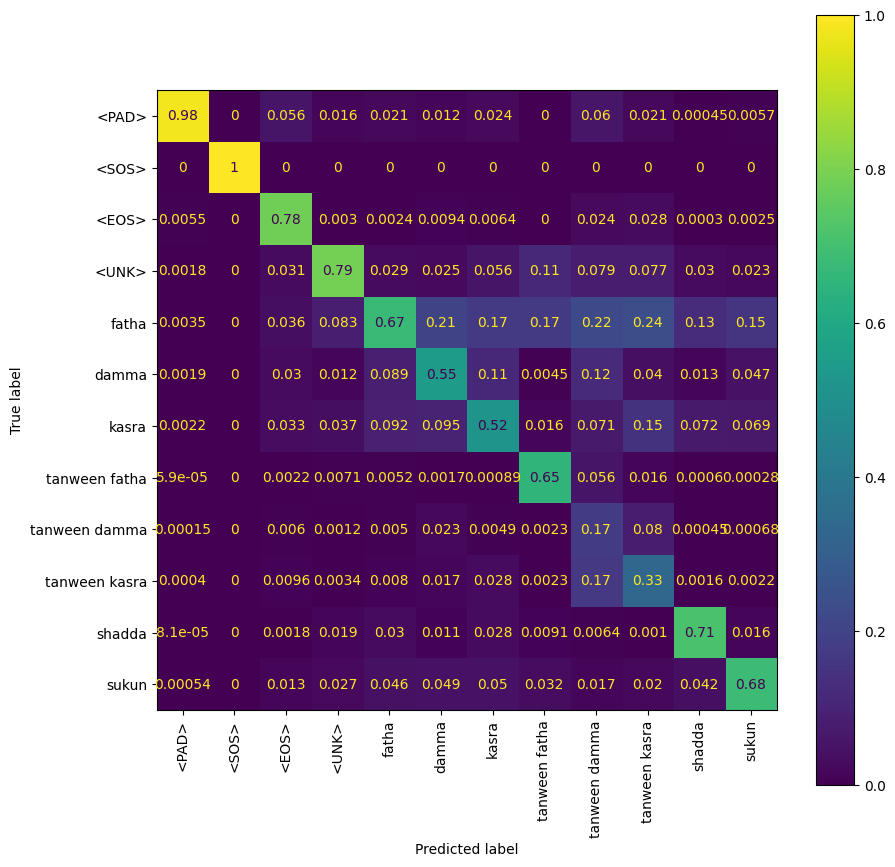

In [173]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
    
# iterate over the first 12 keys in the tokenizer table to get the labels
labels = [get_name(k) for k in list(tokenizer.token2index.keys())[:12]]
print(classification_report(y_true, y_pred,  target_names=labels))

# confusion matrix
cm = confusion_matrix(y_true, y_pred, normalize='pred')
# dimension of the plot
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(ax=ax, xticks_rotation='vertical')
plt.show()